In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
from pathlib import Path
from tqdm import tqdm
import json
import pickle
import numpy as np
import collections
import jieba
from collections import Counter
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics  import f1_score,accuracy_score, confusion_matrix
from sklearn.ensemble import  RandomForestClassifier

In [3]:
%ls ../CRECIL/Final_Data

dev.json  shuffle_data.py  test.json  train.json


In [3]:
with open('../CRECIL/Final_Data/train.json','rb') as infile:
    train_df = json.loads(infile.read())

In [4]:
with open('../CRECIL/Final_Data/dev.json','rb') as infile:
    dev_df = json.loads(infile.read())

In [5]:
with open('../CRECIL/Final_Data/test.json','rb') as infile:
    test_df = json.loads(infile.read())

In [6]:
#data load
with open('../CRECIL/My_home_data/partition1.pickle','rb') as infile:
    partition1 = pickle.load(infile)

In [7]:
with open('rid_to_rel.pickle','rb') as infile:
    rid_to_rel = pickle.load(infile)

with open('rel_to_rid.pickle','rb') as infile:
    rel_to_rid = pickle.load(infile)

### Question 1: 
how does per:alternate_name get predicted, if we have masked names? <br/>
**Answer**: "The model's input consists of a dialogue and a character entity pair to be recognized". I take this to mean that the pairs of entities within the dialogue are given, so models don't have to recreate the pairs from the dialogue itself.

In [8]:
def get_blank_relations(annotations:list) -> list:
    """
    Take the labels and clear out the gold-standard relations, 
    to be filled with predictions by model
    """
    pred_list =[]
    
    for item in annotations:
        copy = item.copy()
        copy['r'] = []
        copy['rid'] = []
        pred_list.append(copy)
    
    return pred_list


def ch_tokenizer(input_str:str):
    #tokenize sentence and return as list
    tokenized = list(jieba.cut(input_str))
    return tokenized

def get_num_speakers(transcript:list)-> int:
    """
    return number of speakers in scene
    """
    ch_set = set()
    for line in transcript:
        ch_set.add(re.findall('S.*(?=:)',line)[0])
    
    total = len(ch_set)
    return total

def dummy_tokenize(phrase): #pass tokenized text version
    return phrase

class results:
    """
    Make an object of the results so that I can get accurate numbers and confusion 
    matrices while sorting for labels.
    """
    def __init__(self,y_test, y_pred):
        self.y_test = y_test
        self.y_pred = y_pred
        self.labels = sorted(list(set(y_test)))
        self.cm = pd.DataFrame(np.zeros(shape=(len(self.labels),len(self.labels)+1))) #initialize to empty
        self.cm[0]=self.labels
        self.cm.columns = ['pred']+self.labels
        self.accuracy = 0
        self.correct = 0
        self.incorrect = 0
        self.label_metrics = dict()
        
        for lab in self.labels:
            self.label_metrics[lab] = dict()
            self.label_metrics[lab]['F1'] = 0.0
            self.label_metrics[lab]['Recall'] = 0.0
            self.label_metrics[lab]['Accuracy'] = 0.0
            self.label_metrics[lab]['TP'] = 0
            self.label_metrics[lab]['TN'] = 0
            self.label_metrics[lab]['FP'] = 0
            self.label_metrics[lab]['FN'] = 0
            self.label_metrics[lab]['cm'] = pd.DataFrame(np.zeros(shape=(2,3)),\
                                                         columns=['']+['Test P','Test N']) #initialize to empty
            self.label_metrics[lab]['cm'][0] = ['Pred P','Pred N']
        
        for i in range(0,len(y_test)):
            
            #update CM
            self.cm.loc[ self.cm['pred'] == y_pred[i], y_test[i]] +=1
            
            if y_pred[i]==y_test[i]:
                self.correct +=1
                self.label_metrics[y_test[i]]['TP'] +=1
                for lab in self.labels:
                    if lab != y_test[i]:
                        self.label_metrics[lab]['TN'] +=1 #all other incorrect labels were not selected
            else:
                self.incorrect +=1
                self.label_metrics[y_test[i]]['FN'] += 1 #true label was not selected
                self.label_metrics[y_pred[i]]['FP'] +=1 #a wrong label was selected
                
                
        self.accuracy = self.correct/(self.correct+self.incorrect)
        for lab in self.labels:
            
            try:
                self.label_metrics[lab]['Precision'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+self.label_metrics[lab]['FP'])
                self.label_metrics[lab]['Recall'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+self.label_metrics[lab]['FN'])
                self.label_metrics[lab]['F1'] = self.label_metrics[lab]['TP']/(self.label_metrics[lab]['TP']+(0.5)*(self.label_metrics[lab]['FP']+self.label_metrics[lab]['FN']))      
                
            except:
                self.label_metrics[lab]['Precision'] = 0
                self.label_metrics[lab]['Recall'] = 0
                self.label_metrics[lab]['F1'] = 0
    def cm(self):
        """
        show cm
        """
        return(self.cm)
    
    def metric(self):
        
        
        print(f"Overall accuracy = {self.accuracy}")
        
        for lab in self.labels:
            print(f"{lab}: {len([item for item in y_test if item==lab])} total")
            print(f"   F1={self.label_metrics[lab]['F1']}")
            print(f"   Precision={self.label_metrics[lab]['Precision']}")
            print(f"   Recall={self.label_metrics[lab]['Recall']}")

        pass


  

In [10]:
rid_to_rel = Counter() #given an rid, return the relation
rel_to_rid = dict() #given a relation, return the rid

for item in train_df:
    for rel in item[1]:
        
        for i in range(0,len(rel['r'])):
            if rel['r'][i] not in rel_to_rid:
                rel_to_rid[rel['r'][i]] = rel['rid'][i]
            if rel['rid'][i] not in rid_to_rel:
                rid_to_rel[rel['rid'][i]] = rel['r'][i]
                
rid_to_rel = collections.OrderedDict(sorted(rid_to_rel.items()))

In [66]:
with open('rid_to_rel.pickle','wb') as outfile:
    pickle.dump(rid_to_rel,outfile,protocol=pickle.HIGHEST_PROTOCOL)

with open('rel_to_rid.pickle','wb') as outfile:
    pickle.dump(rel_to_rid,outfile,protocol=pickle.HIGHEST_PROTOCOL)

Watch [this link](https://www.google.com/search?q=add+features+feature+engineering+one-hot+encoding+with+bert&oq=add+features+feature+engineering+one-hot+encoding+with+bert&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIHCAEQIRigAdIBCTExODI1ajBqN6gCALACAA&sourceid=chrome&ie=UTF-8#fpstate=ive&vld=cid:66503114,vid:NbbsVcs42jE)

Analysis: make a correlation matrix among the 32 relations. Surely per:parent and per:child must occur together frequently

In [38]:
total_dev = 0
for i in range(0,len(dev_df)):
    total_dev += len(dev_df[i][1])
total_dev

7422

In [39]:
dev_df[0][1]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:children'], 'rid': [1]},
 {'x': 'S 1',
  'y': 'S 3',
  'r': ['per:friends', 'per:acquaintance'],
  'rid': [11, 3]},
 {'x': 'S 1', 'y': '小姑', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 1',
  'y': '朝阳叔叔',
  'r': ['per:friends', 'per:acquaintance'],
  'rid': [11, 3]},
 {'x': 'S 1', 'y': '小桂阿姨', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 1',
  'y': '朝阳',
  'r': ['per:friends', 'per:acquaintance'],
  'rid': [11, 3]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 2', 'y': 'S 3', 'r': ['per:acquaintance'], 'rid': [3]},
 {'x': 'S 2', 'y': '小姑', 'r': ['per:relative'], 'rid': [29]},
 {'x': 'S 2', 'y': '朝阳叔叔', 'r': ['per:acquaintance'], 'rid': [3]},
 {'x': 'S 2', 'y': '小桂阿姨', 'r': ['unanswerable'], 'rid': [31]},
 {'x': 'S 2', 'y': '朝阳', 'r': ['per:acquaintance'], 'rid': [3]},
 {'x': 'S 3', 'y': 'S 1', 'r': ['per:friends'], 'rid': [11]},
 {'x': 'S 3', 'y': 'S 2', 'r': ['per:acquaintance'], 'rid': [3]},
 {'x': 'S 3', 'y': '小姑', '

In [37]:
len(dev_df)

116

In [13]:
len(rid_to_rel)

32

In [86]:
#create empty data frame
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel)))
gt_df = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            gt_df.iat[i,j] = 1

In [100]:
Counter(gt_df['per:alternate_name'])

Counter({1.0: 429, 0.0: 53})

In [88]:
corr_matrix = gt_df.corr()

In [89]:
corr_matrix

,per:alternate_name,per:children,per:parents,per:acquaintance,per:client,per:colleague,per:ex-girlfriend,per:girlfriend,per:dates,per:ex-boyfriend,...,per:siblings,per:spouse,per:grandparents,per:grandchildren,per:teacher,per:student,per:roommate,per:relative,per:siblings-in-law,unanswerable
per:alternate_name,1.000000,0.117070,0.117070,0.055997,0.080460,0.085296,0.069229,0.078680,0.063102,0.069229,...,0.069274,0.108441,0.092696,0.092696,0.048484,0.048484,0.016026,0.095654,0.042669,0.090971
per:children,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:parents,0.117070,1.000000,1.000000,-0.006048,-0.033970,-0.037705,-0.128090,-0.150463,-0.115819,-0.128090,...,0.268160,0.516230,0.402224,0.402224,-0.020470,-0.020470,0.027564,0.271393,0.034214,0.099455
per:acquaintance,0.055997,-0.006048,-0.006048,1.000000,-0.043498,-0.021592,-0.022164,-0.013124,0.058844,-0.022164,...,0.039423,0.093797,0.092402,0.092402,0.069985,0.069985,-0.019263,-0.043313,-0.051286,0.027149
per:client,0.080460,-0.033970,-0.033970,-0.043498,1.000000,0.099027,-0.045087,-0.051243,-0.058975,-0.045087,...,-0.081649,-0.087550,-0.056349,-0.056349,-0.031576,-0.031576,-0.010438,-0.102300,-0.027789,0.131067
per:colleague,0.085296,-0.037705,-0.037705,-0.021592,0.099027,1.000000,-0.048390,-0.034804,0.043607,-0.048390,...,-0.139865,-0.025027,-0.025115,-0.025115,-0.055904,-0.055904,-0.018479,-0.099105,0.249716,0.149115
per:ex-girlfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771
per:girlfriend,0.078680,-0.150463,-0.150463,-0.013124,-0.051243,-0.034804,0.777210,1.000000,0.506325,0.777210,...,-0.054955,-0.097220,-0.069105,-0.069105,0.041021,0.041021,-0.010207,0.005557,-0.027174,0.128167
per:dates,0.063102,-0.115819,-0.115819,0.058844,-0.058975,0.043607,0.538054,0.506325,1.000000,0.538054,...,-0.020943,-0.107310,-0.059057,-0.059057,0.027903,0.027903,-0.011747,0.053030,-0.031275,0.087760
per:ex-boyfriend,0.069229,-0.128090,-0.128090,-0.022164,-0.045087,-0.048390,1.000000,0.777210,0.538054,1.000000,...,-0.005680,-0.064143,-0.031815,-0.031815,0.134502,0.134502,-0.008981,0.045175,-0.023910,0.112771


In [96]:
sort(corr_matrix['per:boss'])

[('per:acquaintance', -0.08208033022655042),
 ('per:alternate_name', 0.04169164806752479),
 ('per:boss', 1.0),
 ('per:boyfriend', 0.168066785272256),
 ('per:children', 0.0328757046813823),
 ('per:children-in-law', 0.132118874953544),
 ('per:classmate', 0.03727483722089884),
 ('per:client', -0.034528935855916675),
 ('per:colleague', -0.10766179874679062),
 ('per:dates', 0.09941876083041462),
 ('per:ex-boyfriend', 0.17851966356077914),
 ('per:ex-girlfriend', 0.17851966356077914),
 ('per:friends', -0.09633133550269961),
 ('per:girlfriend', 0.168066785272256),
 ('per:grandchildren', 0.1253900217410204),
 ('per:grandparents', 0.1253900217410204),
 ('per:negative impression', 0.10295738431118671),
 ('per:neighbor', -0.025789516339307476),
 ('per:nickname', -0.0254849056436838),
 ('per:nurse', 0.7588329056007194),
 ('per:parents', 0.0328757046813823),
 ('per:parents-in-law', 0.132118874953544),
 ('per:positive impression', -0.019749396565728463),
 ('per:relative', 0.38772870409144783),
 ('per

Here's a show-specific variable: dialogue-size. I wonder if the rarer relation labels aren't more common only in larger group settings than smaller?

In [116]:
get_num_speakers(train_df[0][0])

4

In [ ]:
#copy code from prev work. 

Main deliberation: these sets of y-variables are co-dependent. Some are very likely to occur together, but it seems harder to model a scenario where a model predicts 5 out of 10 relations, than individually asking: is this relation present or not? 

I'm going to start with the latter problem because I know how to set it up, and then I'm going to research and brainstorm how to set up the first problem.

Short term goal: set up a model that can make predictions based on basic features, and be able to run the evaluation script on it. 

**Step 1**: make a gt data frame with present relations for each dialogue

In [19]:
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel))) #change length
train_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            train_gt.iat[i,j] = 1

zero_data = np.zeros(shape=(len(dev_df),len(rid_to_rel)))
dev_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(dev_df)):
    for rel_item in dev_df[i][1]:
        for j in rel_item['rid']:
            dev_gt.iat[i,j] = 1

zero_data = np.zeros(shape=(len(test_df),len(rid_to_rel)))
test_gt = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(test_df)):
    for rel_item in test_df[i][1]:
        for j in rel_item['rid']:
            test_gt.iat[i,j] = 1

In [9]:
train_array = []
for i in range(0,len(train_df)):
    
    temp = ""
    for row in train_df[i][0]:
        temp += row + '\n'
    train_array.append(temp)

dev_array = []
for i in range(0,len(dev_df)):
    
    temp = ""
    for row in dev_df[i][0]:
        temp += row + '\n'
    dev_array.append(temp)
    
test_array = []
for i in range(0,len(test_df)):
    
    temp = ""
    for row in test_df[i][0]:
        temp += row + '\n'
    test_array.append(temp)

In [12]:
cv = CountVectorizer(tokenizer=ch_tokenizer,ngram_range=(1,3),min_df=2,max_df=0.55)
#train_array,
count_vector=cv.fit_transform(train_array)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.459 seconds.
Prefix dict has been built successfully.


In [13]:
X_train = count_vector.toarray()

In [18]:
X_dev_count = cv.transform(dev_array)
X_dev = X_dev_count.toarray()

X_test_count = cv.transform(test_array)
X_test = X_test_count.toarray()





In [21]:
#rename for consistency
y_train = train_gt
y_test = test_gt

In [28]:
len(dev_gt)

116

In [24]:
# Create feature matrix

#split data if needed
y = train_gt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




In [29]:
y_train.columns

Index(['per:alternate_name', 'per:children', 'per:parents', 'per:acquaintance',
       'per:client', 'per:colleague', 'per:ex-girlfriend', 'per:girlfriend',
       'per:dates', 'per:ex-boyfriend', 'per:boyfriend', 'per:friends',
       'per:nickname', 'per:neighbor', 'per:nurse', 'per:parents-in-law',
       'per:children-in-law', 'per:positive impression', 'per:classmate',
       'per:negative impression', 'per:subordinate', 'per:boss',
       'per:siblings', 'per:spouse', 'per:grandparents', 'per:grandchildren',
       'per:teacher', 'per:student', 'per:roommate', 'per:relative',
       'per:siblings-in-law', 'unanswerable'],
      dtype='object')

In [22]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train, y_train['per:roommate']).predict(X_test)

In [23]:
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test['per:roommate'] != y_pred).sum()))
Counter(y_pred) 

Number of mislabeled points out of a total 71 points : 0


Counter({0.0: 71})

In [33]:

#fit
SVM = SVC(kernel = 'linear')
SVM.fit(X_train,y_train['per:roommate'])
y_pred=SVM.predict(X_dev)

In [34]:
print("Number of mislabeled points out of a total %d points : %d"% (X_dev.shape[0], (dev_gt['per:roommate'] != y_pred).sum()))
Counter(y_pred)

Number of mislabeled points out of a total 116 points : 0


Counter({0.0: 116})

In [29]:
#evaluate
print(accuracy_score(y_test['per:roommate'],y_pred))
print(f1_score(y_test['per:roommate'],y_pred))
confusion_matrix(y_test['per:roommate'], y_pred) #even more the case than the Logistic Regression

1.0
0.0


/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


array([[71]])

In [ ]:

neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()[::-1]

In [ ]:


"""
clf.classes_  gives array(['tu', 'vous'], dtype='<U4')
so the second one, 1, is vous, and that's what's getting shown in the 
pos_class
"""
print(clf.classes_)
print(np.take(count.get_feature_names(), neg_class_prob_sorted[:10]))
print(np.take(count.get_feature_names(), pos_class_prob_sorted[:10])) 

Jul 14

In [9]:
#make ground truth of 9 labels 
y = []
X = []
for scene in partition1:
    for line in scene:
        y.append(line['rel_pair'])
        #remove non-characters
        no_punct = [word for word in line['tokenized'] if bool(re.search(r'[\u4e00-\u9fff]',word))] 
        X.append(no_punct)
Counter(y)

Counter({'children_parents': 115,
         'parents_children': 117,
         'relative_relative': 36,
         'siblings_siblings': 10,
         'spouse_spouse': 454,
         'grandparents_grandchildren': 77,
         'grandchildren_grandparents': 73,
         'parents-in-law_children-in-law': 229,
         'children-in-law_parents-in-law': 235})

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [11]:
Counter(y_test)

Counter({'children_parents': 27,
         'spouse_spouse': 86,
         'parents_children': 25,
         'parents-in-law_children-in-law': 49,
         'children-in-law_parents-in-law': 39,
         'siblings_siblings': 2,
         'grandparents_grandchildren': 20,
         'grandchildren_grandparents': 15,
         'relative_relative': 7})

In [11]:
cv = CountVectorizer(tokenizer=dummy_tokenize,lowercase=False) #,ngram_range=(1,3),min_df=2,max_df=0.55

count_vector=cv.fit_transform(X_train)

X_train = count_vector.toarray()

X_test = cv.transform(X_test)

In [12]:
SVM_feature_names = cv.get_feature_names()

/home2/elyeb/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
SVM_feature_names

['BP机',
 '一',
 '一一',
 '一下',
 '一两年',
 '一个',
 '一个十二岁',
 '一个样儿',
 '一举',
 '一九七六年',
 '一二一',
 '一五一十',
 '一些',
 '一人',
 '一份',
 '一会儿',
 '一位',
 '一儿',
 '一共',
 '一动不动',
 '一半',
 '一去不回',
 '一双',
 '一口气',
 '一句',
 '一只',
 '一名',
 '一回',
 '一圈',
 '一场',
 '一块',
 '一块儿',
 '一声',
 '一夜',
 '一大',
 '一大块',
 '一大家子',
 '一大帮',
 '一大早',
 '一天',
 '一天到晚',
 '一头',
 '一套',
 '一定',
 '一封',
 '一封信',
 '一年',
 '一张',
 '一张一驰',
 '一张新来',
 '一当',
 '一惯',
 '一所',
 '一把',
 '一支',
 '一支花',
 '一新',
 '一时',
 '一月',
 '一条',
 '一样',
 '一根',
 '一概',
 '一模一样',
 '一次',
 '一步',
 '一段',
 '一比',
 '一水儿',
 '一点',
 '一点儿',
 '一片',
 '一百',
 '一盆',
 '一盏',
 '一眼',
 '一知已',
 '一码事',
 '一破歌',
 '一种',
 '一站',
 '一等奖',
 '一粒',
 '一股',
 '一般',
 '一说',
 '一起',
 '一趟',
 '一路上',
 '一辆',
 '一辈子',
 '一边',
 '一通',
 '一遍',
 '一部分',
 '一间',
 '一阵风',
 '一顿',
 '一颗',
 '七十年代',
 '七千万两',
 '七根',
 '万',
 '万一',
 '万一出',
 '万个',
 '万亩',
 '万分',
 '万吨',
 '万能',
 '丈夫',
 '三',
 '三八作风',
 '三分之二',
 '三封',
 '三点',
 '三百',
 '三角',
 '三长两短',
 '三顿',
 '上',
 '上去',
 '上台',
 '上头',
 '上学',
 '上官云珠',
 '上帝',
 '上床',
 '上当受骗',
 '上志新',
 '上次',
 '上班',
 '上签',
 '上要',
 '下',

In [13]:
#fit
SVM = SVC(kernel = 'linear')
SVM.fit(count_vector,y_train)
y_pred=SVM.predict(X_test)

In [43]:
X_train.shape

(1076, 3602)

In [44]:
X_test.shape

(270, 3602)

In [16]:
SVM.coef_.shape

(36, 3602)

In [37]:
SVM.coef_

<36x3602 sparse matrix of type '<class 'numpy.float64'>'
	with 23685 stored elements in Compressed Sparse Row format>

Question: why does this have 36 rows?

Note from stackoverflow: "If you do multi-class classification scikit-learn employs a one-vs-one scheme. This means you get one separate classifier (or one set of weights) for each combination of classes. If C is the number of classes there is a total of C * (C-1) / 2 combinations." <br/> <br/> This checks out for my data (9*8/2 = 36)

In [17]:
SVM.classes_

array(['children-in-law_parents-in-law', 'children_parents',
       'grandchildren_grandparents', 'grandparents_grandchildren',
       'parents-in-law_children-in-law', 'parents_children',
       'relative_relative', 'siblings_siblings', 'spouse_spouse'],
      dtype='<U30')

From the [documentation](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification), "The order for classes 0 to n is “0 vs 1”, “0 vs 2” , … “0 vs n”, “1 vs 2”, “1 vs 3”, “1 vs n”, . . . “n-1 vs n”."

So, using the order of the SVM.classes_ I see the following:

In [16]:
row = 0
row_names = []
for i in range(0,len(SVM.classes_)-1):
    for j in range(i+1,len(SVM.classes_)):
        print(f'{row} : {SVM.classes_[i]} vs {SVM.classes_[j]}')
        row_names.append(SVM.classes_[i]+' vs '+SVM.classes_[j])
        row +=1

0 : children-in-law_parents-in-law vs children_parents
1 : children-in-law_parents-in-law vs grandchildren_grandparents
2 : children-in-law_parents-in-law vs grandparents_grandchildren
3 : children-in-law_parents-in-law vs parents-in-law_children-in-law
4 : children-in-law_parents-in-law vs parents_children
5 : children-in-law_parents-in-law vs relative_relative
6 : children-in-law_parents-in-law vs siblings_siblings
7 : children-in-law_parents-in-law vs spouse_spouse
8 : children_parents vs grandchildren_grandparents
9 : children_parents vs grandparents_grandchildren
10 : children_parents vs parents-in-law_children-in-law
11 : children_parents vs parents_children
12 : children_parents vs relative_relative
13 : children_parents vs siblings_siblings
14 : children_parents vs spouse_spouse
15 : grandchildren_grandparents vs grandparents_grandchildren
16 : grandchildren_grandparents vs parents-in-law_children-in-law
17 : grandchildren_grandparents vs parents_children
18 : grandchildren_gra

In [63]:
coef_df = pd.DataFrame(SVM.coef_.todense(),columns=SVM_feature_names)

In [101]:
n = 10
i = 0
label = row_names[i]

full_array = coef_df.iloc[i,]
top_n = sorted(sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n],key=lambda x: x[1])
bottom_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1])[0:n]

In [87]:
top_n

[('挨', 0.6416969087372876),
 ('瞅', 0.6439453681938341),
 ('大爷', 0.6580559036552821),
 ('贾淑芬', 0.6841286418464124),
 ('哎', 0.6841328650392957),
 ('啊', 0.6841543905866336),
 ('嗳', 0.6841555540870627),
 ('卡迪拉克', 0.6841669115966372),
 ('嗯', 0.6842125827741787),
 ('可不', 0.9656798881660905)]

In [88]:
bottom_n #this is clearly the second class. So bottom_n is stronger to second class

[('喂', -0.840915333509046),
 ('钥匙', -0.8448081948939732),
 ('啦', -0.9092278315671167),
 ('开会', -0.9210273215716112),
 ('明白', -0.9726740848232749),
 ('随便', -0.984200251195382),
 ('真的', -1.0),
 ('舶', -1.0),
 ('妈', -1.1991786048555315),
 ('妈妈', -1.315835586886018)]

Text(0.5, 1.0, 'tata')


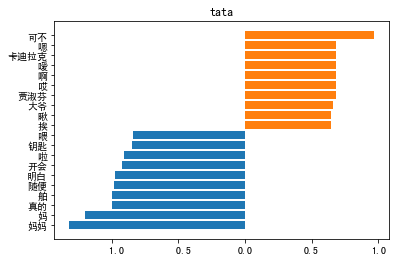

In [120]:
plt.rcParams['font.sans-serif'] = ['SimHei']

plt.barh([item[0] for item in bottom_n],[item[1] for item in bottom_n])
plt.barh([item[0] for item in top_n],[item[1] for item in top_n])
print(plt.title("tata"))

In [128]:
def get_top_features(n,i,coef_df,feature_names,label):
    
    plt.rcParams['font.sans-serif'] = ['SimHei']

    full_array = coef_df.iloc[i,]
    top_n = sorted(sorted(list(zip(feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n],key=lambda x: x[1])
    bottom_n = sorted(list(zip(feature_names,full_array)), key=lambda x: x[1])[0:n] 

    plt.barh([item[0] for item in bottom_n],[item[1] for item in bottom_n])
    plt.barh([item[0] for item in top_n],[item[1] for item in top_n])
    print(plt.title(label))


Text(0.5, 1.0, 'children-in-law_parents-in-law vs children_parents')


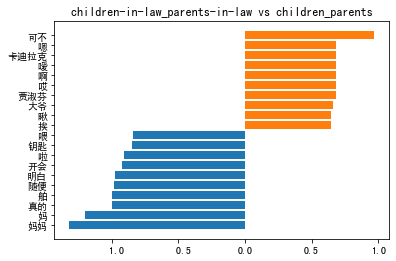

In [129]:
get_top_features(10,0,coef_df,SVM_feature_names,row_names[0])

Text(0.5, 1.0, 'children-in-law_parents-in-law vs grandchildren_grandparents')


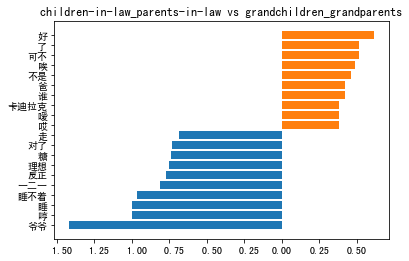

In [130]:
get_top_features(10,1,coef_df,SVM_feature_names,row_names[1])

Text(0.5, 1.0, 'children-in-law_parents-in-law vs grandparents_grandchildren')


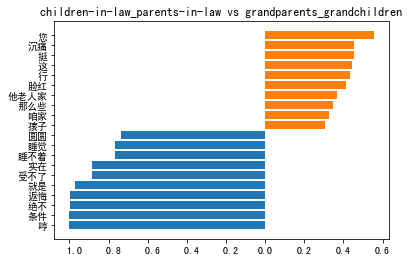

In [131]:
get_top_features(10,2,coef_df,SVM_feature_names,row_names[2])

In [134]:
#Make a dictionary of above results

top_10s = dict()
cross_cutting = dict()

for i in range(0,len(row_names)):
    
    label = row_names[i]

    full_array = coef_df.iloc[i,]
    top_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1],reverse=True)[0:n]
    bottom_n = sorted(list(zip(SVM_feature_names,full_array)), key=lambda x: x[1])[0:n]
    
    x = label.split(' vs ')[0]
    y = label.split(' vs ')[0]
    
    top_10s[label] = dict()
    top_10s[label]['top_n'] = top_n
    top_10s[label]['bottom_n'] = bottom_n
    
    if x not in cross_cutting:
        cross_cutting[x] = []
    cross_cutting[x].append([item[0] for item in top_n])
    
    if y not in cross_cutting:
        cross_cutting[y] = []
    cross_cutting[y].append([item[0] for item in bottom_n])

In [135]:
cross_cutting['children-in-law_parents-in-law']

[['可不', '嗯', '卡迪拉克', '嗳', '啊', '哎', '贾淑芬', '大爷', '瞅', '挨'],
 ['妈妈', '妈', '真的', '舶', '随便', '明白', '开会', '啦', '钥匙', '喂'],
 ['好', '了', '可不', '唉', '不是', '爸', '谁', '卡迪拉克', '嗳', '哎'],
 ['爷爷', '哼', '睡', '睡不着', '一二一', '反正', '理想', '糖', '对了', '走'],
 ['您', '挺', '沉痛', '这', '行', '脸红', '他老人家', '那么些', '咱家', '孩子'],
 ['哼', '条件', '绝不', '返悔', '就是', '受不了', '实在', '睡不着', '睡觉', '圆圆'],
 ['您', '他老人家', '可不', '嗯', '爸', '唉', '卡迪拉克', '大爷', '脸红', '贾淑芬'],
 ['多少', '嗨', '哼', '哦', '哎呀', '作风', '坐', '干什么', '这个', '对'],
 ['您', '脸红', '叫', '沉痛', '抓', '爸', '人', '你们', '哟', '起来'],
 ['噢', '为什么', '行', '嘿', '要说', '吓死', '这个', '吨数', '呢', '是不是'],
 ['您', '脸红', '可不', '没有', '正', '一个', '他老人家', '呐', '咱家', '爸'],
 ['累', '水下', '潜艇', '别', '肥皂', '知道', '根本', '味儿', '喘气', '不吃'],
 ['您', '了', '啊', '这', '听见', '就', '该', '瞅', '他', '怎么'],
 ['换房', '骗', '算', '唔', '外头', '刘颖', '在', '不要', '大方向', '开涮'],
 ['您', '爸', '卡迪拉克', '可不', '脸红', '该', '贾淑芬', '咱家', '唉', '太'],
 ['同学', '目的', '现实', '贼胆', '回事儿', '残酷', '坏', '和平', '病源', '平易近人']]

In [132]:
test = 'children-in-law_parents-in-law vs grandparents_grandchildren'
test.split(' vs ')

['children-in-law_parents-in-law', 'grandparents_grandchildren']

In [62]:
SVM.coef_.shape

(36, 3602)

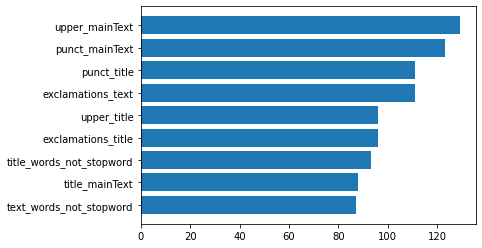

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['title_mainText', 'upper_title', 'upper_mainText', 'punct_title', 'punct_mainText',
                  'exclamations_title', 'exclamations_text', 'title_words_not_stopword', 'text_words_not_stopword']

n_classes = 4
n_features = len(features_names)

clf_coef_ = np.random.randint(1, 30, size=(int(0.5*n_classes*(n_classes-1)), n_features))

f_importances(clf_coef_.sum(axis=0), features_names)

In [32]:
SVM.decision_function()

TypeError: decision_function() missing 1 required positional argument: 'X'

In [13]:
Counter(y_pred)

Counter({'children-in-law_parents-in-law': 30,
         'parents_children': 14,
         'parents-in-law_children-in-law': 72,
         'spouse_spouse': 100,
         'relative_relative': 5,
         'children_parents': 24,
         'grandchildren_grandparents': 11,
         'grandparents_grandchildren': 14})

In [14]:
Counter(y_test)

Counter({'children_parents': 27,
         'spouse_spouse': 86,
         'parents_children': 25,
         'parents-in-law_children-in-law': 49,
         'children-in-law_parents-in-law': 39,
         'siblings_siblings': 2,
         'grandparents_grandchildren': 20,
         'grandchildren_grandparents': 15,
         'relative_relative': 7})

In [15]:
print("Number of mislabeled points out of a total %d points : %d"% (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled points out of a total 270 points : 171


In [25]:
#evaluate
print(accuracy_score(y_test,y_pred))
#print(f1_score(y_test,y_pred))
confusion_matrix(y_test, y_pred) #even more the case than the Logistic Regression

0.34814814814814815


array([[17,  5,  2,  2,  7,  0,  0,  0,  6],
       [ 4,  6,  2,  1,  4,  1,  1,  1,  7],
       [ 3,  3,  4,  1,  3,  0,  0,  0,  1],
       [ 4,  1,  2,  2,  5,  3,  0,  0,  3],
       [ 3,  1,  2,  4, 21,  3,  0,  0, 15],
       [ 1,  1,  1,  2,  9,  1,  0,  0, 10],
       [ 0,  1,  0,  0,  3,  0,  1,  0,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 7,  5,  4,  7, 16,  4,  1,  0, 42]])

In [37]:
resuls_cm = results(y_test,y_pred)
resuls_cm.metric()
test_cm = resuls_cm.cm
test_cm

Overall accuracy = 0.36666666666666664
children-in-law_parents-in-law: 39 total
   F1=0.4057971014492754
   Precision=0.4666666666666667
   Recall=0.358974358974359
children_parents: 27 total
   F1=0.3137254901960784
   Precision=0.3333333333333333
   Recall=0.2962962962962963
grandchildren_grandparents: 15 total
   F1=0.46153846153846156
   Precision=0.5454545454545454
   Recall=0.4
grandparents_grandchildren: 20 total
   F1=0.11764705882352941
   Precision=0.14285714285714285
   Recall=0.1
parents-in-law_children-in-law: 49 total
   F1=0.38016528925619836
   Precision=0.3194444444444444
   Recall=0.46938775510204084
parents_children: 25 total
   F1=0.05128205128205128
   Precision=0.07142857142857142
   Recall=0.04
relative_relative: 7 total
   F1=0.0
   Precision=0.0
   Recall=0.0
siblings_siblings: 2 total
   F1=0
   Precision=0
   Recall=0
spouse_spouse: 86 total
   F1=0.4838709677419355
   Precision=0.45
   Recall=0.5232558139534884


,pred,children-in-law_parents-in-law,children_parents,grandchildren_grandparents,grandparents_grandchildren,parents-in-law_children-in-law,parents_children,relative_relative,siblings_siblings,spouse_spouse
0,children-in-law_parents-in-law,14.0,2.0,3.0,2.0,2.0,1.0,1.0,0.0,5.0
1,children_parents,5.0,8.0,2.0,1.0,1.0,2.0,1.0,0.0,4.0
2,grandchildren_grandparents,2.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,1.0
3,grandparents_grandchildren,2.0,0.0,0.0,2.0,4.0,2.0,0.0,0.0,4.0
4,parents-in-law_children-in-law,5.0,3.0,2.0,6.0,23.0,11.0,2.0,0.0,20.0
5,parents_children,1.0,3.0,0.0,1.0,2.0,1.0,0.0,0.0,6.0
6,relative_relative,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7,siblings_siblings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,spouse_spouse,8.0,9.0,2.0,7.0,17.0,7.0,3.0,2.0,45.0


Despite the poor results, there are 3 pairs that it seems to pick up on pretty well (unknown because CM isn't labelled). The others are all scattered. Note: I also didn't do any CV or anything to fine-tune feature-selection

In [42]:
#X, y = diabetes.data, diabetes.target
clf=RandomForestClassifier(n_estimators =50) #, random_state = 42, class_weight="balanced"
output = cross_validate(clf, X_train, y_train, cv=2, scoring = 'accuracy', return_estimator =True)

In [43]:
output

{'fit_time': array([0.18427181, 0.18705082]),
 'score_time': array([0.01380229, 0.01344109]),
 'estimator': [RandomForestClassifier(n_estimators=50),
  RandomForestClassifier(n_estimators=50)],
 'test_score': array([0.44981413, 0.45724907])}

In [45]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       #index = diabetes.feature_names,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
      importance
1704    0.037014
461     0.022532
2110    0.015081
3290    0.014815
2480    0.013002
...          ...
1590    0.000000
1592    0.000000
1593    0.000000
1595    0.000000
3601    0.000000

[3602 rows x 1 columns]
Features sorted by their score for estimator 1:
      importance
461     0.027471
1704    0.025952
1762    0.019465
2587    0.010419
2480    0.010198
...          ...
1614    0.000000
1615    0.000000
1616    0.000000
1617    0.000000
3601    0.000000

[3602 rows x 1 columns]
